In [38]:
#BAD BAD NOT GOOD DATA PROCESSING THAT USES BESPOKE TOOLS

In [27]:
from aind_dynamic_foraging_data_utils import nwb_utils
import aind_dynamic_foraging_basic_analysis.licks.annotation as annotation
import glob
import os
import numpy as np
%matplotlib inline
%matplotlib ipympl
from aind_dynamic_foraging_basic_analysis.plot import plot_session_scroller as pss 
import matplotlib.pyplot as plt

In [28]:
nwb_files = glob.glob('../data/**/nwb/**.nwb')

In [29]:
# # Get the absolute path to the data directory
# data_dir = '/Users/lauradriscoll/Documents/code/aind_ssm_hackathon/data'

# # Use glob to find all .nwb files in the data directory and its subdirectories
# nwb_files = glob.glob(os.path.join(data_dir, '**', 'nwb', '*.nwb'), recursive=True)

In [30]:
nwb = nwb_utils.load_nwb_from_filename(nwb_files[0])

In [31]:
nwb.df_trials = nwb_utils.create_df_trials(nwb)
nwb.df_events = nwb_utils.create_events_df(nwb)
nwb.fip_df = nwb_utils.create_fib_df(nwb, tidy=True)
nwb.df_licks = annotation.annotate_lick_bouts(nwb)
nwb.df_licks = annotation.annotate_rewards(nwb)
nwb.df_licks = annotation.annotate_cue_response(nwb)

/src/aind-dynamic-foraging-data-utils/src/aind_dynamic_foraging_data_utils/nwb_utils.py:380: RuntimeWarning: All-NaN slice encountered
  lambda x: np.nanmin(
/src/aind-dynamic-foraging-data-utils/src/aind_dynamic_foraging_data_utils/nwb_utils.py:397: RuntimeWarning: All-NaN slice encountered
  lambda x: np.nanmin(np.concatenate([[np.nan], x["right_lick_time"], x["left_lick_time"]])),


In [32]:
import numpy as np
import pandas as pd

def organize_nwb_data(nwb, fluorescence_event = "G_1_dff-poly", interpolate_step=0.1):
    """
    Organize NWB data for dopamine state space modeling.
    
    Parameters:
    nwb : NWBFile
        The NWB file object containing the data
    fluorescence_event : str
        The name of the fluorescence event in nwb.fip_df
    interpolate_step : float, optional
        The time step for interpolation (default is 0.1)
    
    Returns:
    pd.DataFrame
        A dataframe containing the organized data
    """
    # Get events data
    events_df = nwb_utils.create_events_df(nwb)
    
    # Get all unique event types
    event_types = np.unique(events_df['event'])
    
    # Get fluorescence data
    fip_df = nwb.fip_df
    t = fip_df.query(f'event=="{fluorescence_event}"')['timestamps']
    f = fip_df.query(f'event=="{fluorescence_event}"')['data']
    
    if len(t) == 0 or len(f) == 0:
        raise ValueError(f"No data found for fluorescence event '{fluorescence_event}'. Please check the event name.")
    
    # Create a unified time axis
    t_start = min(t.min(), events_df['timestamps'].min())
    t_end = max(t.max(), events_df['timestamps'].max())
    t_unified = np.arange(t_start, t_end, interpolate_step)
    
    # Interpolate fluorescence data to unified time axis
    f_unified = np.interp(t_unified,t, f)
    
    # Create event signals
    event_signals = pd.DataFrame(index=t_unified, columns=event_types)
    for event_type in event_types:
        event_times = events_df[events_df['event'] == event_type]['timestamps']
        event_signals[event_type] = 0
        event_indices = np.searchsorted(t_unified, event_times)
        event_indices = event_indices[event_indices < len(t_unified)]  # Ensure indices are within bounds
        event_signals.iloc[event_indices, event_signals.columns.get_loc(event_type)] = 1
        
    # Combine all data into a single DataFrame
    combined_data = pd.DataFrame({
        'time': t_unified,
        'dopamine_signal': f_unified,
        'goCue_start_time': event_signals['goCue_start_time'],
        'left_lick_time': event_signals['left_lick_time'],
        'left_reward_delivery_time': event_signals['left_reward_delivery_time'],
        'right_lick_time': event_signals['right_lick_time'],
        'right_reward_delivery_time': event_signals['right_reward_delivery_time']

    })


    return combined_data, event_signals

In [33]:
combined_data, event_signals = organize_nwb_data(nwb, interpolate_step=0.1)

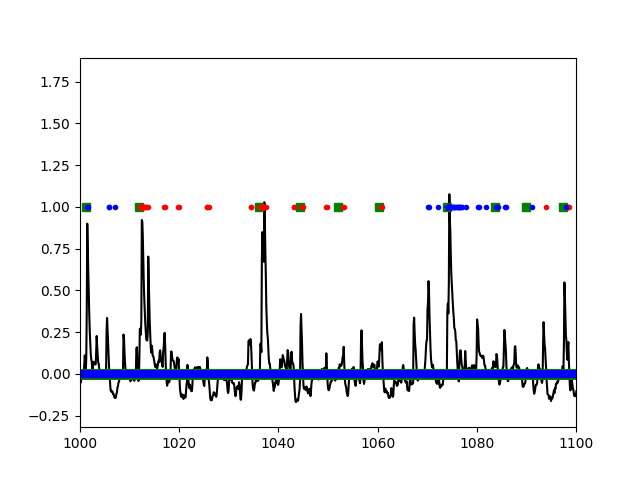

In [37]:
plt.close()
t_start = 0
t_max = len(combined_data['dopamine_signal'])

plt.plot(2*combined_data['dopamine_signal'].loc[t_start:t_max],'-k')
plt.plot(combined_data['goCue_start_time'].loc[t_start:t_max],'sg')
plt.plot(combined_data['right_reward_delivery_time'].loc[t_start:t_max],'*r')
plt.plot(combined_data['right_lick_time'].loc[t_start:t_max],'.r')
plt.plot(combined_data['left_reward_delivery_time'].loc[t_start:t_max],'*b')
plt.plot(combined_data['left_lick_time'].loc[t_start:t_max],'.b')

plt.xlim([1000, 1100])
plt.show()